In [1]:
import sys
sys.path.append('/net/hypernova/data2/BOOMPJE/code/ic_generation/')

import numpy as np
import read_tipsy
import os
from astropy.cosmology import WMAP9 as cosmo

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib
plt.rcParams['figure.dpi'] = 360
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['text.usetex'] = True
rc("animation", html = "jshtml")

In [13]:
def read_parameters(path):
    log = {}
    with open(f'/net/hypernova/data2/BOOMPJE/{path}/parameters.log') as f:
        f = f.readlines()
        for line in f:
            key, value = line.strip().split(':')
            try:
                log[key.strip()] = float(value.strip())
            except:
                log[key.strip()] = value.strip()
    return log

def separate_ids(sim_path):
    _, m, _, _, _, _, _, _, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path}/stacked_objects')
    ids.sort()
    cen_ids = ids[:int(1e6)]
    return cen_ids

def separate_halos(cen_ids, sim_path):
    _, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path}')
    mask = np.isin(ids, cen_ids)
    halos = {
        'cen': {
            'pos': np.column_stack((x[mask], y[mask], z[mask])),
            'vel': np.column_stack((vx[mask], vy[mask], vz[mask])),
            'm': m[mask]},
        'sat': {
            'pos': np.column_stack((x[~mask], y[~mask], z[~mask])),
            'vel': np.column_stack((vx[~mask], vy[~mask], vz[~mask])),
            'm': m[~mask]}}
    return halos

def load_data(directory):
    direc = f'/net/hypernova/data2/BOOMPJE/{directory}'
    files = [f for f in os.listdir(direc) if f.startswith('evolution')]
    files.sort()
    time = []
    for file in files:
        time.append(read_tipsy.read_file(f'{direc}/{file}')[0][0])
    return (1/15)*np.array(time)*(1/cosmo.H0.value), files

def find_dense_center_median(positions):
    median_center = np.median(positions, axis=0)
    return median_center

def calculate_distances(positions, center):
    distances = np.linalg.norm(positions - center, axis=1)
    return distances

def calculate_mass_density(distances, masses, num_bins=100):
    hist, bin_edges = np.histogram(distances, bins=num_bins, weights=masses)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_volumes = 4/3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    density = hist / bin_volumes
    return bin_centers, density

### 
---

### $r(t)$ behavior

In [14]:
def find_r(sim_path, ids, files):
    d = np.zeros(len(files))
    for i, f in enumerate(files):
        halos = separate_halos(ids, f'{sim_path}/{f}')
        median_center_cen = np.median(halos['cen']['pos'], axis=0)
        median_center_sat = np.median(halos['sat']['pos'], axis=0)
        d[i] = np.linalg.norm(median_center_cen - median_center_sat)
    return d

In [15]:
def find_tau_wt(path, threshold=1e-3):  #! 0.1% of the max ampl
    param = read_parameters(path)
    ids = separate_ids(path)
    t, t_files = load_data(path)
    r = find_r(path, ids, t_files)
    dr = np.gradient(r, t)
    ddr = np.gradient(dr, t)
    threshold = threshold*max(ddr)
    index = int(np.median(np.where(np.abs(ddr) < threshold)))
    return r, t, t[index]

#### Changing the number of part

In [16]:
def separate_halos_mod(cen_ids, sim_path, n):
    _, m, x, y, z, vx, vy, vz, ids = read_tipsy.read_file(f'/net/hypernova/data2/BOOMPJE/{sim_path}')
    mask = np.isin(ids, cen_ids)
    ind = int(len(mask)*n)
    halos = {
        'cen': {
            'pos': np.column_stack((x[mask], y[mask], z[mask]))[:ind],
            'vel': np.column_stack((vx[mask], vy[mask], vz[mask]))[:ind],
            'm': m[mask][:ind]},
        'sat': {
            'pos': np.column_stack((x[~mask], y[~mask], z[~mask]))[:ind],
            'vel': np.column_stack((vx[~mask], vy[~mask], vz[~mask]))[:ind],
            'm': m[~mask][:ind]}}
    return halos

def find_r_mod(sim_path, ids, files):
    d = np.zeros(len(files))
    for i, f in enumerate(files):
        halos = separate_halos_mod(ids, f'{sim_path}/{f}', 0.3)
        median_center_cen = np.median(halos['cen']['pos'], axis=0)
        median_center_sat = np.median(halos['sat']['pos'], axis=0)
        d[i] = np.linalg.norm(median_center_cen - median_center_sat)
    return d

def find_tau_wt_mod(path, threshold=1e-3):  #! 0.1% of the max ampl
    param = read_parameters(path)
    ids = separate_ids(path)
    t, t_files = load_data(path)
    r = find_r_mod(path, ids, t_files)
    dr = np.gradient(r, t)
    ddr = np.gradient(dr, t)
    threshold = threshold*max(ddr)
    index = int(np.median(np.where(np.abs(ddr) < threshold)))
    return r, t, t[index]

In [17]:
r, t, ti = find_tau_wt('merging_0_1072098')

In [18]:
r1, t1, ti1 = find_tau_wt_mod('merging_0_1072098')

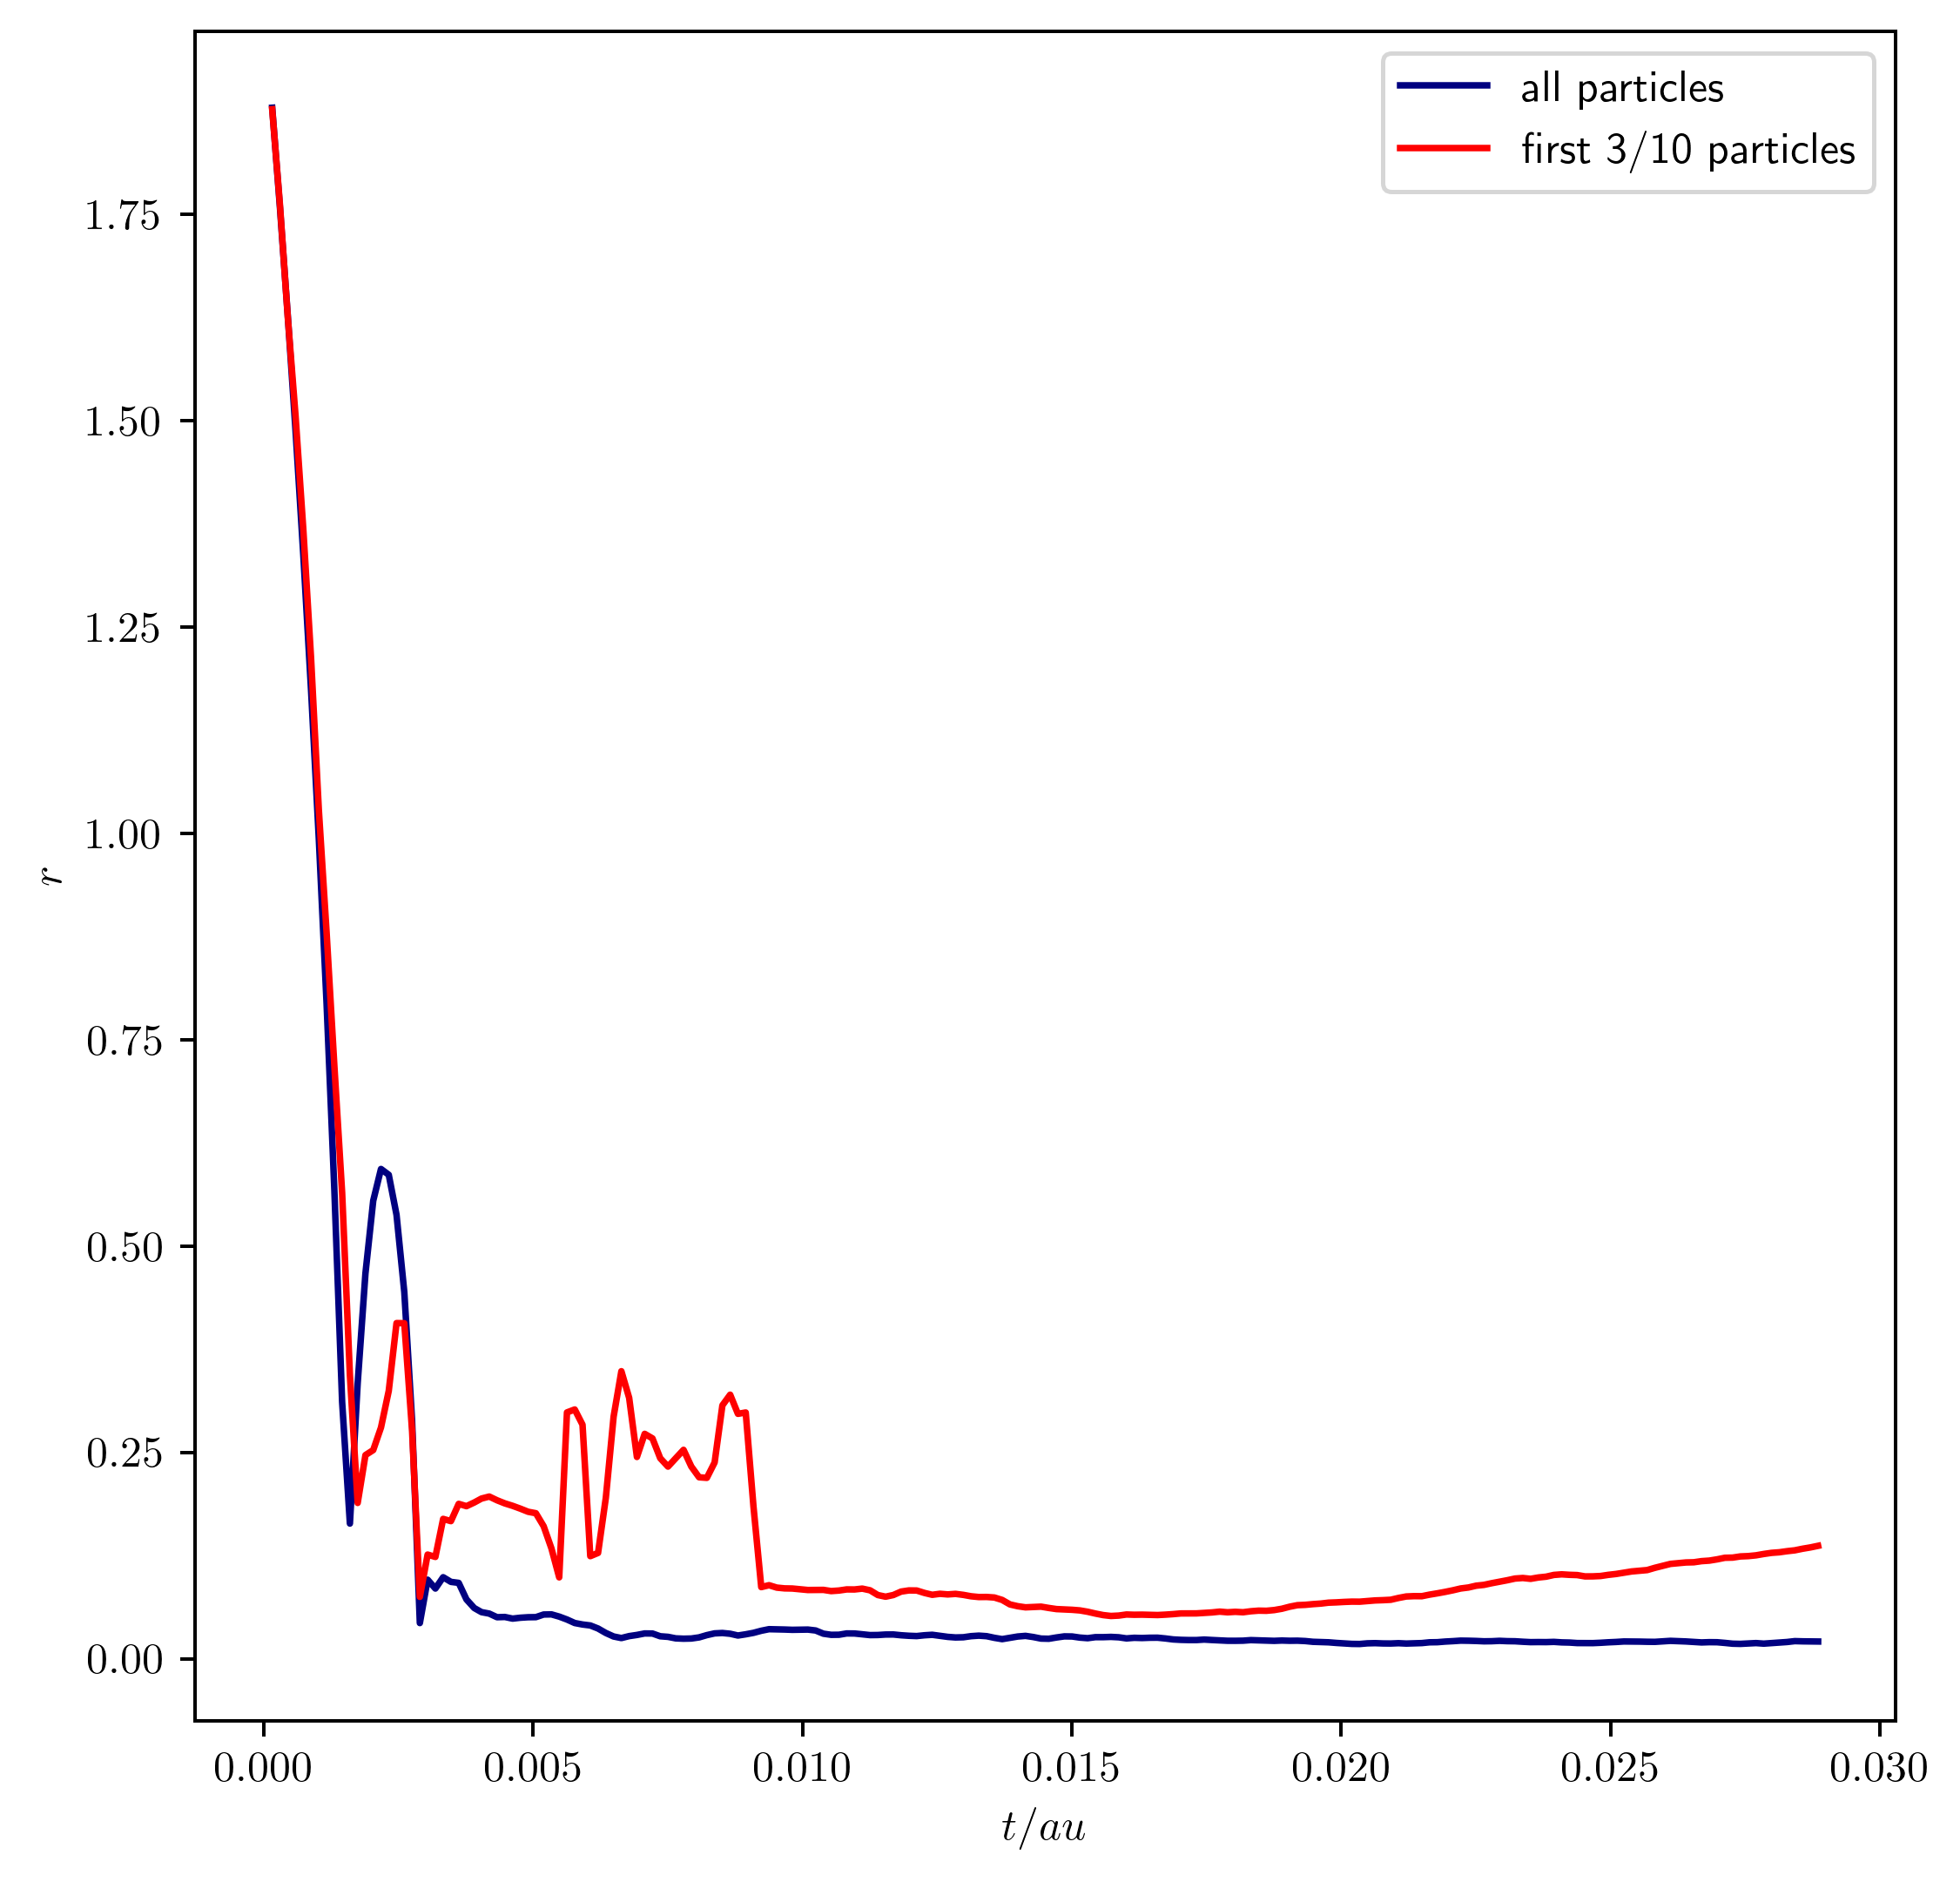

In [28]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(t, r, label='all particles', c='navy')
ax.plot(t1, r1, label='first 3/10 particles', c='red')
ax.set_xlabel('$t/\tau$')
ax.set_ylabel('$r$')
plt.legend()
plt.show()